In [2]:
# Importing Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [3]:
df = pd.read_csv("Delivery_Logistics.csv")
df.head()

,delivery_id,delivery_partner,package_type,vehicle_type,delivery_mode,region,weather_condition,distance_km,package_weight_kg,delivery_time_hours,expected_time_hours,delayed,delivery_status,delivery_rating,delivery_cost
0,250.99,delhivery,automobile parts,bike,same day,west,clear,297.0,46.96,1970-01-01 00:00:00.000000008,1970-01-01 00:00:00.000000008,no,delivered,3,1632.7206
1,250.99,xpressbees,cosmetics,ev van,express,central,cold,89.6,47.39,1970-01-01 00:00:00.000000002,1970-01-01 00:00:00.000000003,no,delivered,5,640.1700
2,250.99,shadowfax,groceries,truck,two day,east,rainy,273.5,26.89,1970-01-01 00:00:00.000000010,1970-01-01 00:00:00.000000016,no,delivered,4,1448.1700
3,250.99,dhl,electronics,ev van,same day,east,cold,269.7,12.69,1970-01-01 00:00:00.000000006,1970-01-01 00:00:00.000000008,no,delivered,3,1486.5700
4,250.99,dhl,clothing,van,two day,north,foggy,256.7,37.02,1970-01-01 00:00:00.000000009,1970-01-01 00:00:00.000000016,no,delivered,4,1394.5600


In [7]:
# Convert both delivery time columns into numeric hours
df["actual_hours"] = pd.to_datetime(df["delivery_time_hours"]).dt.nanosecond
df["expected_hours"] = pd.to_datetime(df["expected_time_hours"]).dt.nanosecond

# Drop old columns
df = df.drop(columns=["delivery_time_hours", "expected_time_hours"])

df[["actual_hours", "expected_hours"]].head()

,actual_hours,expected_hours
0,8,8
1,2,3
2,10,16
3,6,8
4,9,16


In [9]:
# 1. Delay in hours
df["delay_hours"] = df["actual_hours"] - df["expected_hours"]

# 2. Operational speed
df["speed_kmph"] = df["distance_km"] / df["actual_hours"].replace(0, np.nan)

# 3. Cost per km
df["cost_per_km"] = df["delivery_cost"] / df["distance_km"]

# 4. Heavy package flag
df["heavy_package_flag"] = (df["package_weight_kg"] > 20).astype(int)

# 5. Bad weather flag
df["bad_weather_flag"] = df["weather_condition"].isin(["rainy", "foggy", "stormy"]).astype(int)

# 6. Region + partner combined feature
df["region_partner"] = df["region"] + "_" + df["delivery_partner"]

df.head()

,delivery_id,delivery_partner,package_type,vehicle_type,delivery_mode,region,weather_condition,distance_km,package_weight_kg,delayed,...,delivery_rating,delivery_cost,actual_hours,expected_hours,delay_hours,speed_kmph,cost_per_km,heavy_package_flag,bad_weather_flag,region_partner
0,250.99,delhivery,automobile parts,bike,same day,west,clear,297.0,46.96,no,...,3,1632.7206,8,8,0,37.125000,5.497376,1,0,west_delhivery
1,250.99,xpressbees,cosmetics,ev van,express,central,cold,89.6,47.39,no,...,5,640.1700,2,3,-1,44.800000,7.144754,1,0,central_xpressbees
2,250.99,shadowfax,groceries,truck,two day,east,rainy,273.5,26.89,no,...,4,1448.1700,10,16,-6,27.350000,5.294954,1,1,east_shadowfax
3,250.99,dhl,electronics,ev van,same day,east,cold,269.7,12.69,no,...,3,1486.5700,6,8,-2,44.950000,5.511939,0,0,east_dhl
4,250.99,dhl,clothing,van,two day,north,foggy,256.7,37.02,no,...,4,1394.5600,9,16,-7,28.522222,5.432645,1,1,north_dhl


In [11]:
#rows where the target (actual_hours) is missing
df = df.dropna(subset=["actual_hours"])

In [13]:
#Replacing infinity values caused by division
df["speed_kmph"] = df["speed_kmph"].replace([np.inf, -np.inf], np.nan)
df["cost_per_km"] = df["cost_per_km"].replace([np.inf, -np.inf], np.nan)

In [15]:
#Filling all numeric NaNs with median values
numeric_cols = [
    "distance_km","package_weight_kg","expected_hours",
    "delay_hours","speed_kmph","cost_per_km","delivery_rating"
]

df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

In [17]:
# binary flag NaNs
df["heavy_package_flag"] = df["heavy_package_flag"].fillna(0)
df["bad_weather_flag"] = df["bad_weather_flag"].fillna(0)

In [19]:
#replacing categorical NaNs with "Unknown"
categorical_cols = [
    "delivery_partner","package_type","vehicle_type","delivery_mode",
    "region","weather_condition","region_partner","delivery_status"
]

df[categorical_cols] = df[categorical_cols].fillna("Unknown")

In [21]:
df.isna().sum().sum()


0

### Feature Matrix (X) and Target (y)

In [24]:
# Numeric columns (cleaned before)
num_cols = [
    "distance_km","package_weight_kg","expected_hours",
    "delay_hours","speed_kmph","cost_per_km","delivery_rating"
]

# Binary flags
binary_cols = ["heavy_package_flag","bad_weather_flag"]

# Categorical features
cat_cols = [
    "delivery_partner","package_type","vehicle_type","delivery_mode",
    "region","weather_condition","region_partner","delivery_status"
]

# Feature matrix
X = df[num_cols + binary_cols + cat_cols]

# Target variable
y = df["actual_hours"]

X.head(), y.head()

(   distance_km  package_weight_kg  expected_hours  delay_hours  speed_kmph  \
 0        297.0              46.96               8            0   37.125000   
 1         89.6              47.39               3           -1   44.800000   
 2        273.5              26.89              16           -6   27.350000   
 3        269.7              12.69               8           -2   44.950000   
 4        256.7              37.02              16           -7   28.522222   
 
    cost_per_km  delivery_rating  heavy_package_flag  bad_weather_flag  \
 0     5.497376                3                   1                 0   
 1     7.144754                5                   1                 0   
 2     5.294954                4                   1                 1   
 3     5.511939                3                   0                 0   
 4     5.432645                4                   1                 1   
 
   delivery_partner      package_type vehicle_type delivery_mode   region  \
 

### Train/Test/Split

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((20000, 17), (5000, 17))

In [32]:
numeric_preprocess = Pipeline([
    ("scaler", StandardScaler())
])

categorical_preprocess = Pipeline([
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_preprocess, num_cols + binary_cols),
        ("cat", categorical_preprocess, cat_cols)
    ]
)

### Linear Regression (Baseline Model)

In [35]:
lr_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

lr_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Random Forest Regressor (Better Non-linear Model)


In [38]:
rf_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

rf_model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [40]:
from xgboost import XGBRegressor

xgb_model = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

xgb_model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [44]:
def evaluate(model, X_test, y_test):
    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    mse = mean_squared_error(y_test, preds)
    rmse = np.sqrt(mse)   # Manual RMSE, works everywhere
    r2 = r2_score(y_test, preds)
    return mae, rmse, r2


In [46]:
lr_results = evaluate(lr_model, X_test, y_test)
rf_results = evaluate(rf_model, X_test, y_test)
xgb_results = evaluate(xgb_model, X_test, y_test)

lr_results, rf_results, xgb_results

((2.7879116004929382e-05, 3.432332389242582e-05, 0.9999999998783843),
 (0.025408666666666656, 0.0850141818234529, 0.999253905261075),
 (0.07952237129211426, 0.1201038818433196, 0.9985108971595764))

In [50]:
(lr_results)

(2.7879116004929382e-05, 3.432332389242582e-05, 0.9999999998783843)

In [52]:
(rf_results)

(0.025408666666666656, 0.0850141818234529, 0.999253905261075)

In [54]:
(xgb_results)

(0.07952237129211426, 0.1201038818433196, 0.9985108971595764)

In [56]:
# RF model
rf = rf_model.named_steps["model"]

# OneHotEncoder categories
ohe = rf_model.named_steps["preprocessor"].named_transformers_["cat"].named_steps["onehot"]

# feature names
encoded_cat_features = list(ohe.get_feature_names_out(cat_cols))

# all features (numeric + binary + encoded categorical)
final_features = num_cols + binary_cols + encoded_cat_features
len(final_features), len(rf.feature_importances_)

(96, 96)

In [58]:
# Putting importance values into a DataFrame
fi_df = pd.DataFrame({
    "feature": final_features,
    "importance": rf.feature_importances_
})

# Sort by importance
fi_df = fi_df.sort_values(by="importance", ascending=False)

fi_df.head(20)

,feature,importance
0,distance_km,0.540481
4,speed_kmph,0.338813
8,bad_weather_flag,0.104927
44,weather_condition_foggy,0.012323
3,delay_hours,0.002004
5,cost_per_km,0.000318
47,weather_condition_stormy,0.000260
46,weather_condition_rainy,0.000119
1,package_weight_kg,0.000086
2,expected_hours,0.000054


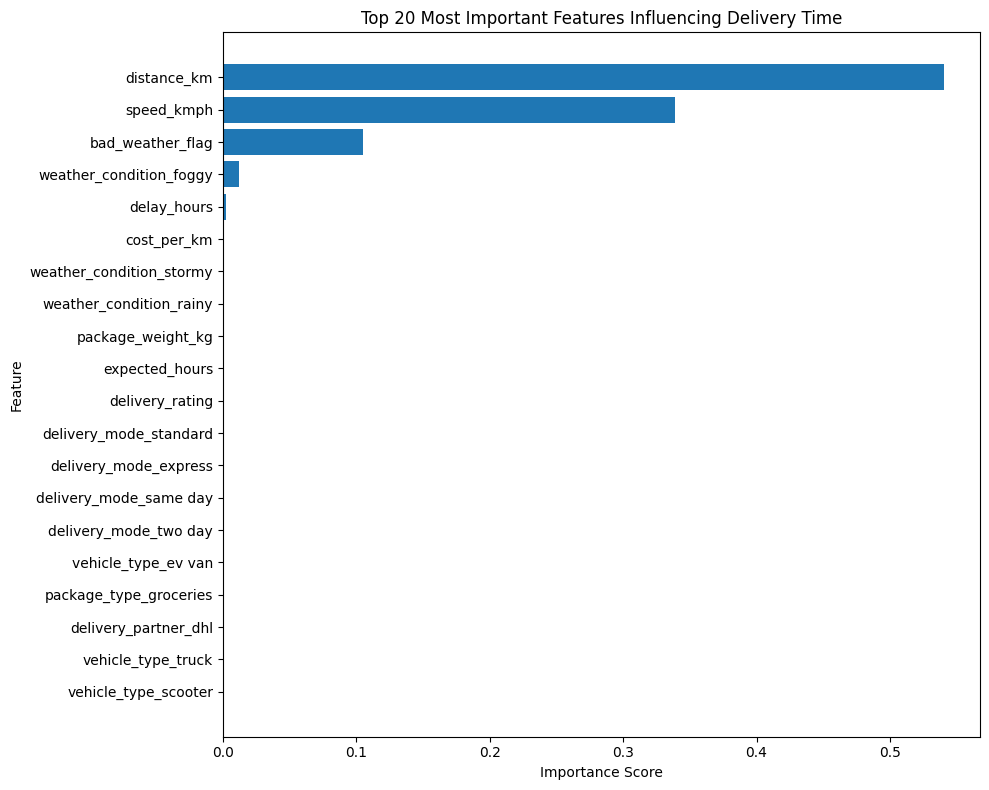

In [60]:
# top 20 features
top_n = 20
top_features = fi_df.head(top_n)

plt.figure(figsize=(10, 8))
plt.barh(top_features["feature"][::-1], top_features["importance"][::-1])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 20 Most Important Features Influencing Delivery Time")
plt.tight_layout()
plt.show()


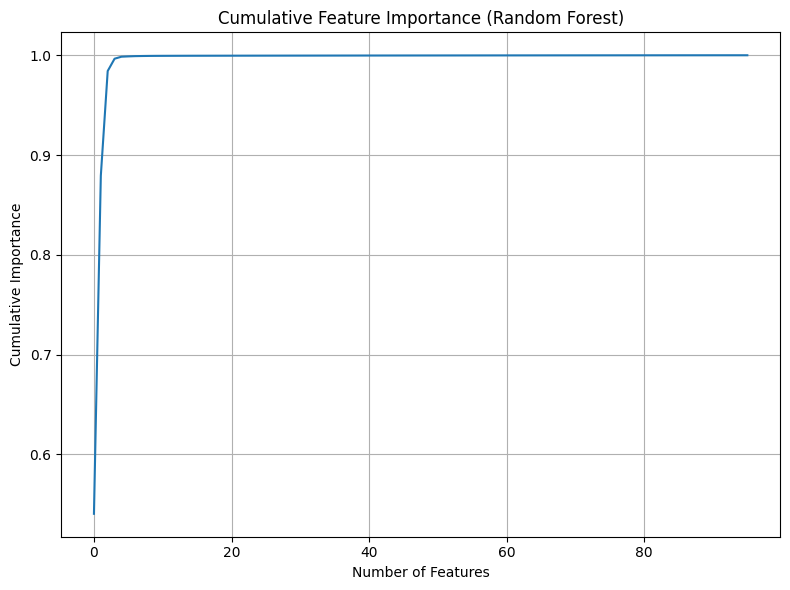

In [62]:
# Compute cumulative importance
fi_df["cumulative_importance"] = fi_df["importance"].cumsum()

plt.figure(figsize=(8, 6))
plt.plot(fi_df["cumulative_importance"].values)
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Importance")
plt.title("Cumulative Feature Importance (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()
